# STOCK PRICE PREDICTION USING DEEP LEARNING

# Step 1: Import Required Libraries python and loading the data



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split



# Load the dataset from your local file (adjust file path if needed)
data = pd.read_csv('AAPL1.csv')

# Print the first few rows of the dataset to inspect it
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


# Step 2: Preprocess the Data (Select 'Date' and 'Close' Columns)

Here, we select the Date and Close columns, convert the Date column to datetime, and set it as the index.


In [2]:
# Use 'Date' and 'Close' columns for prediction
data = data[['Date', 'Close']]

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Print the first few rows after setting 'Date' as index
data.head()


,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


# Step 3: Normalize the Data Using Min-Max Scaling
This step scales the Close prices to be between 0 and 1, which helps the LSTM model train more efficiently.

In [3]:
# Normalize the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Print a sample of the scaled data
print(scaled_data[:5])


[[0.00043548]
 [0.00039868]
 [0.00034961]
 [0.00036495]
 [0.00038335]]


# Step 4: Prepare Data for LSTM (Create Sequences)
This function creates sequences of 60 time steps and uses the next day's price as the target value.

In [4]:
# Prepare the data for LSTM by creating sequences (60 time steps)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Time steps
        y.append(data[i + time_step, 0])  # Target (next day's price)
    return np.array(X), np.array(y)

# Set the time step (number of previous days to consider)
time_step = 60

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Print the shapes of X and y
print(X.shape, y.shape)


(10348, 60) (10348,)


Reshaping input data for LSTM is necessary because LSTM models expect input in a 3D shape: `(samples, time_steps, features)`. 

- **Samples**: Number of sequences in your data.
- **Time_steps**: Number of previous time steps (e.g., 60 days) the model looks at to predict the next value.
- **Features**: The number of variables (e.g., closing price) used for each time step.

For example, if you use 60 days of stock data to predict the 61st day, your data should be reshaped into `(number_of_sequences, 60, 1)` where `1` is the number of features (closing price).

Reshaping ensures the LSTM can process sequential data and learn patterns over time.

# Step 5: Reshape Data for LSTM Input
The LSTM model expects data with the shape [samples, time_steps, features], so we need to reshape the data accordingly.

In [5]:
# Reshape input data for LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Print the shape of X after reshaping
print(X.shape)


(10348, 60, 1)


# Step 6: Split Data into Training and Testing Sets
We will split the data into 80% for training and 20% for testing.

In [6]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print the shapes of the training and testing sets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(8278, 60, 1) (8278,)
(2070, 60, 1) (2070,)


# Step 7: Build the LSTM Model
Now we define and compile the LSTM model.

In [7]:
# Build the LSTM model
model = Sequential()

# Add the first LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Add the second LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=False))

# Add the output layer with 1 unit
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# Step 8: Train the Model
Here, we train the model with the training data for 10 epochs.

In [8]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 1.0678e-04
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.4593e-06
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.1154e-06
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 2.2824e-06
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 2.3590e-06
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.6904e-06
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.2274e-06
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.4544e-06
Epoch 9/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 1.7088e-06
Epoch 10/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1.5577e-06


# Step 9: Make Predictions
After training, we use the trained model to make predictions on the test data.

In [9]:
# Make predictions on the test data
predicted_stock_price = model.predict(X_test)

# Inverse transform the predicted and actual prices back to original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print the first few predicted values
print(predicted_stock_price[:5])


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
[[20.297386]
 [20.194914]
 [20.081347]
 [19.9574  ]
 [19.86043 ]]


# Step 10: Visualize the Results
Finally, visualize the predicted stock prices and the actual stock prices.

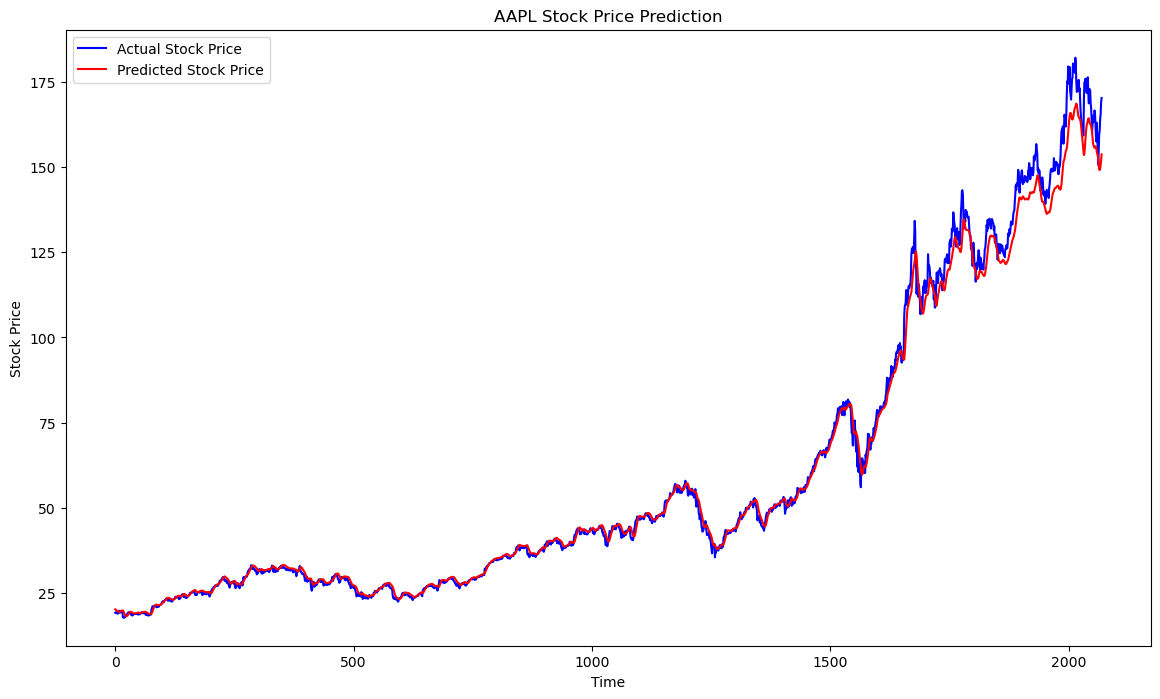

In [10]:
# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


The visual plots the actual stock prices (in blue) against the predicted stock prices (in red) over time. It helps compare how well the LSTM model's predictions match the actual values, showing the model's performance. The x-axis represents time, and the y-axis represents stock prices.